In [1]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from geopandas.tools import overlay
import matplotlib.pyplot as plt
import os 
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
import xgboost as xgb
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, mean_squared_error
#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Dense
#from tensorflow.keras.utils import to_categorical

## Espacios Públicos Cdmx

In [2]:
schema = 'espacios_publicos'
table = 'ep_cdmx'
gdf = aup.gdf_from_db(table,schema)
gdf.head()

,id,geo_point_2d,geo_shape,subcat_sed,subcve_sed,gid,cve_delg,delegacion,categoria,superficie,perimetro,cve_sedema,geometry
0,0,"19.4877568178,-99.2060645931","{'type': 'MultiPolygon', 'coordinates': [[[[-9...",Panteones,604,268,2,Azcapotzalco,Equipamientos urbanos con vegetación,6660.027554,329.264738,600,"POLYGON ((-99.20639 19.48819, -99.20556 19.487..."
1,1,"19.3887689803,-99.116393168","{'type': 'MultiPolygon', 'coordinates': [[[[-9...",Deportivos,601,87,8,Iztacalco,Equipamientos urbanos con vegetación,2917.257837,272.2436142,600,"POLYGON ((-99.11679 19.38904, -99.11637 19.388..."
2,2,"19.3928871121,-99.0869912505","{'type': 'MultiPolygon', 'coordinates': [[[[-9...",Camellones centrales y laterales,203,180,8,Iztacalco,Áreas verdes complementarias o ligadas a la re...,1086.305646,425.0436555,200,"POLYGON ((-99.08651 19.39367, -99.08648 19.393..."
3,3,"19.383106069,-99.1073609486","{'type': 'MultiPolygon', 'coordinates': [[[[-9...",Unidades habitacionales,602,89,8,Iztacalco,Equipamientos urbanos con vegetación,3605.704046,269.2094365,600,"POLYGON ((-99.10780 19.38333, -99.10688 19.383..."
4,4,"19.3822134465,-99.1028423436","{'type': 'MultiPolygon', 'coordinates': [[[[-9...",Unidades habitacionales,602,90,8,Iztacalco,Equipamientos urbanos con vegetación,19619.36158,798.4092267,600,"POLYGON ((-99.10389 19.38315, -99.10355 19.383..."


In [4]:
gdf.shape

(11609, 13)

## Hexágonos Cdmx

In [3]:
hex_schema = "raster_analysis"
hex_table = "ndvi_analysis_hex"
c = 'ZMVM'
n = '11'
query = f'SELECT hex_id, geometry, city FROM {hex_schema}.{hex_table} WHERE \"city\" LIKE \'{c}\' AND \"res\" = {n}'
hex_gdl = aup.gdf_from_query(query, geometry_col='geometry')
#query = 'fSelect geometry, hex_id, city from raster_analysis.ndvi_analysis where city = guadalajara and res = 11'
hex_gdl.head(5)

,hex_id,geometry,city
0,8b4995b81405fff,"POLYGON ((-99.15333 19.47087, -99.15315 19.471...",ZMVM
1,8b4995b814e2fff,"POLYGON ((-99.15254 19.47346, -99.15237 19.473...",ZMVM
2,8b4995b81420fff,"POLYGON ((-99.15345 19.46991, -99.15328 19.470...",ZMVM
3,8b4995b8154dfff,"POLYGON ((-99.15736 19.47056, -99.15718 19.470...",ZMVM
4,8b4995b81595fff,"POLYGON ((-99.14914 19.46897, -99.14896 19.469...",ZMVM


In [6]:
hex_gdl.shape

(300000, 3)

In [4]:
gdf = gdf.to_crs(hex_gdl.crs)
print("CRS of gdf:", gdf.crs)
print("CRS of hex_gdl:", hex_gdl.crs)

CRS of gdf: epsg:4326
CRS of hex_gdl: epsg:4326


## Dummy Variables
1 = Hexágonos que cuentan con espacios públicos

0 = Hexágonos que no cuentan con espacios públicos

In [5]:
gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
intersects_public_spaces = hex_gdl['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

hex_gdl['EspPublico'] = intersects_public_spaces.astype(int)
hex_gdl.head()

,hex_id,geometry,city,EspPublico
0,8b4995b81405fff,"POLYGON ((-99.15333 19.47087, -99.15315 19.471...",ZMVM,0
1,8b4995b814e2fff,"POLYGON ((-99.15254 19.47346, -99.15237 19.473...",ZMVM,1
2,8b4995b81420fff,"POLYGON ((-99.15345 19.46991, -99.15328 19.470...",ZMVM,0
3,8b4995b8154dfff,"POLYGON ((-99.15736 19.47056, -99.15718 19.470...",ZMVM,1
4,8b4995b81595fff,"POLYGON ((-99.14914 19.46897, -99.14896 19.469...",ZMVM,0


In [9]:
contador_ceros = np.sum(hex_gdl['EspPublico'] == 0)
contador_uno = np.sum(hex_gdl['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}\nNúmero total de Hexágonos: {contador_ceros+contador_uno}')

Números de hexagonos sin Espacios Públicos: 220800 
Número de Hexágonos con Espacios Públicos: 79200
Número total de Hexágonos: 300000


Casi el 75% de los hexágonos no cuenta con Espacio Público, los métodos de clasificación van a estar muy sesgados por la discrepancia. Entonces tenemos que hacer que sean 50% ambos pero para esto vamos a hacer un submuestreo random con 150,000 y 150,000 de cada tipo de hexágono pero eso se hará después de juntar todo con el otro GeoDataFrame. Esto es porque nada más tenemos 300,000 hexágonos comparados al de Guadalajara que tenía 400,000.

## Hexágonos con info de humedad, vegetación.

select {ndmi}.hex_id, {ndmi}.geometry, {ndmi}.city, {ndmi}.res,

ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,

ndmi_mean, ndmi_median, ndmi_diff

from raster_analysis.ndmi_analysis_hex ndmi

inner join raster_analysis.ndvi_analysis_hex ndvi

on ndmi.hex_id = ndvi.hex_id 

where ndmi.city  = 'ZMVM' and ndmi.res = 11

In [6]:
hex_schema = "raster_analysis"
hex_tablee = "ndvi_analysis_hex"
hex_table = "ndmi_analysis_hex"
ndmi = "ndmi"
ndvi = "ndvi"
hex_id = "hex_id"
c = 'ZMVM'
n = '11'
query = f'SELECT {ndmi}.hex_id, {ndmi}.geometry, {ndmi}.city, {ndmi}.res, ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,ndmi_mean, ndmi_median, ndmi_diff FROM {hex_schema}.{hex_table} {ndmi} INNER JOIN {hex_schema}.{hex_tablee} {ndvi} ON {ndmi}.{hex_id} = {ndvi}.{hex_id} WHERE {ndmi}.\"city\" = \'{c}\' AND {ndmi}.\"res\" = {n}'
intt_gdl = aup.gdf_from_query(query, geometry_col='geometry')
intt_gdl.head(10)

,hex_id,geometry,city,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff
0,8b4995b8dd5dfff,"POLYGON ((-99.19998 19.49063, -99.19981 19.490...",ZMVM,11,0.183130,0.062578,0.194367,0.257773,0.086611,0.171162,-0.000180,0.004920,-0.009944,0.158101
1,8b4995b8e154fff,"POLYGON ((-99.16119 19.49214, -99.16101 19.492...",ZMVM,11,-0.022569,0.028222,-0.019269,-0.000936,-0.076509,0.075573,-0.000084,-0.049077,-0.062853,0.181300
2,8b4995b8dc83fff,"POLYGON ((-99.19348 19.49287, -99.19330 19.493...",ZMVM,11,0.137634,0.059429,0.156930,0.197662,0.031899,0.165763,-0.000713,0.002228,-0.005155,0.126045
3,8b4995b8dc8efff,"POLYGON ((-99.19388 19.49315, -99.19371 19.493...",ZMVM,11,0.084169,0.037411,0.098810,0.115045,0.014396,0.100649,-0.000377,-0.044239,-0.063996,0.151630
4,8b4995b8dc31fff,"POLYGON ((-99.19648 19.49026, -99.19630 19.490...",ZMVM,11,0.061729,0.026972,0.061135,0.085542,0.016240,0.069302,0.000471,-0.064496,-0.065611,0.172864
5,8b4995b8dc43fff,"POLYGON ((-99.19961 19.49351, -99.19943 19.493...",ZMVM,11,0.209839,0.083443,0.246651,0.293106,0.082181,0.210925,-0.001006,0.031399,0.018582,0.122100
6,8b4995b8dda4fff,"POLYGON ((-99.19464 19.48739, -99.19446 19.487...",ZMVM,11,0.150437,0.050493,0.165970,0.195888,0.077331,0.118557,-0.000156,-0.003881,-0.017095,0.116238
7,8b4995b8e860fff,"POLYGON ((-99.16679 19.48664, -99.16661 19.486...",ZMVM,11,0.044500,0.030981,0.047927,0.075759,-0.012823,0.088582,-0.000337,-0.076269,-0.099490,0.208478
8,8b4995b8d21efff,"POLYGON ((-99.20632 19.50663, -99.20615 19.506...",ZMVM,11,0.053968,0.028454,0.057982,0.082012,0.005677,0.076335,-0.000499,-0.041400,-0.055059,0.118447
9,8b4995b8d345fff,"POLYGON ((-99.21108 19.50421, -99.21090 19.504...",ZMVM,11,0.228300,0.084620,0.264800,0.298903,0.114548,0.184355,-0.000765,0.062162,0.056676,0.076875


In [11]:
intt_gdl.shape

(299918, 14)

## Intersección

In [7]:
intt_gdl = intt_gdl.set_crs("EPSG:4326")
hex_gdl = hex_gdl.set_crs("EPSG:4326")

In [8]:
inter = gpd.sjoin(hex_gdl, intt_gdl, op='intersects')
inter.drop(columns=['index_right','city_right','res','hex_id_right'], inplace=True)
inter.rename(columns={"hex_id_left": "hex_id","city_left": "city"}, inplace=True)
inter.head()

,hex_id,geometry,city,EspPublico,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff
0,8b4995b81405fff,"POLYGON ((-99.15333 19.47087, -99.15315 19.471...",ZMVM,0,0.094694,0.041706,0.104945,0.134444,0.029785,0.10466,-0.000536,-0.009775,-0.026843,0.124114
2,8b4995b81420fff,"POLYGON ((-99.15345 19.46991, -99.15328 19.470...",ZMVM,0,0.094694,0.041706,0.104945,0.134444,0.029785,0.10466,-0.000536,-0.009775,-0.026843,0.124114
148,8b4995b8142efff,"POLYGON ((-99.15380 19.47067, -99.15362 19.470...",ZMVM,0,0.094694,0.041706,0.104945,0.134444,0.029785,0.10466,-0.000536,-0.009775,-0.026843,0.124114
299807,8b4995b81422fff,"POLYGON ((-99.15298 19.47010, -99.15281 19.470...",ZMVM,0,0.094694,0.041706,0.104945,0.134444,0.029785,0.10466,-0.000536,-0.009775,-0.026843,0.124114
299811,8b4995b81421fff,"POLYGON ((-99.15386 19.47019, -99.15368 19.470...",ZMVM,0,0.094694,0.041706,0.104945,0.134444,0.029785,0.10466,-0.000536,-0.009775,-0.026843,0.124114


In [9]:
pd.isna(inter).sum()

hex_id         0
geometry       0
city           0
EspPublico     0
ndvi_mean      0
ndvi_std       0
ndvi_median    0
ndvi_max       0
ndvi_min       0
ndvi_diff      0
ndvi_tend      0
ndmi_mean      0
ndmi_median    0
ndmi_diff      0
dtype: int64

In [10]:
cont_ceros = np.sum(inter['EspPublico'] == 0)
cont_uno = np.sum(inter['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_ceros} \nNúmero de Hexágonos con Espacios Públicos: {cont_uno}\nNúmero total de Hexágonos: {cont_ceros+cont_uno}')

Números de hexagonos sin Espacios Públicos: 1528834 
Número de Hexágonos con Espacios Públicos: 552051
Número total de Hexágonos: 2080885


In [11]:
inter['EspPublico'].unique()

array([0, 1])

## Submuestreo 150,000 Hexágonos Esp Púb x 150,000 Hexágonos No Esp Púb

In [12]:
num_samples = 150000

# Randomly sample 203,570 hexagons with public spaces
sample_with_public_spaces = inter[inter['EspPublico'] == 1].sample(n=num_samples, random_state=42)

# Randomly sample 203,570 hexagons without public spaces
sample_without_public_spaces = inter[inter['EspPublico'] == 0].sample(n=num_samples, random_state=42)

# Concatenate the two samples to get the final subsample
inter = pd.concat([sample_with_public_spaces, sample_without_public_spaces])
inter.reset_index(drop = True, inplace = True)
inter.head()

,hex_id,geometry,city,EspPublico,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff
0,8b4995aa4459fff,"POLYGON ((-99.14626 19.54507, -99.14608 19.545...",ZMVM,1,0.073286,0.045207,0.080575,0.110494,-0.014418,0.124912,-0.000453,-0.056574,-0.069866,0.205583
1,8b4995b15ccbfff,"POLYGON ((-99.25531 19.38281, -99.25513 19.383...",ZMVM,1,0.187339,0.047990,0.198820,0.235221,0.108858,0.126362,-0.000654,0.034693,0.025850,0.097522
2,8b49958e655afff,"POLYGON ((-99.00542 19.28836, -99.00524 19.288...",ZMVM,1,0.032214,0.030879,0.033241,0.083296,-0.018006,0.101302,-0.000464,-0.044433,-0.057564,0.163503
3,8b49958c135bfff,"POLYGON ((-99.03099 19.37983, -99.03081 19.380...",ZMVM,1,0.335218,0.120720,0.381861,0.449127,0.154848,0.294278,-0.001125,0.110334,0.108866,0.104404
4,8b49958cc808fff,"POLYGON ((-99.04790 19.37919, -99.04773 19.379...",ZMVM,1,0.318747,0.154151,0.293153,0.628651,0.120642,0.508009,-0.001998,0.012045,-0.006807,0.350358


In [13]:
contador_ceros = np.sum(inter['EspPublico'] == 0)
contador_uno = np.sum(inter['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}\nNúmero total de Hexágonos: {contador_ceros+contador_uno}')

Números de hexagonos sin Espacios Públicos: 150000 
Número de Hexágonos con Espacios Públicos: 150000
Número total de Hexágonos: 300000


In [14]:
inter.shape

(300000, 14)

Ya está balanceada la base de datos y con un submuestreo random. Entonces ya podemos juntarlo con el otro GeoDataFrame

Verificamos duplicados

## Métodos de Clasificación

In [15]:
x = inter[['ndvi_mean','ndvi_std','ndvi_median','ndvi_max','ndvi_min','ndvi_diff','ndvi_tend','ndmi_mean','ndmi_median','ndmi_diff']]
y = inter['EspPublico']

In [16]:
y.unique()

array([1, 0])

### Regresión Logística

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.fit_transform(x_test)

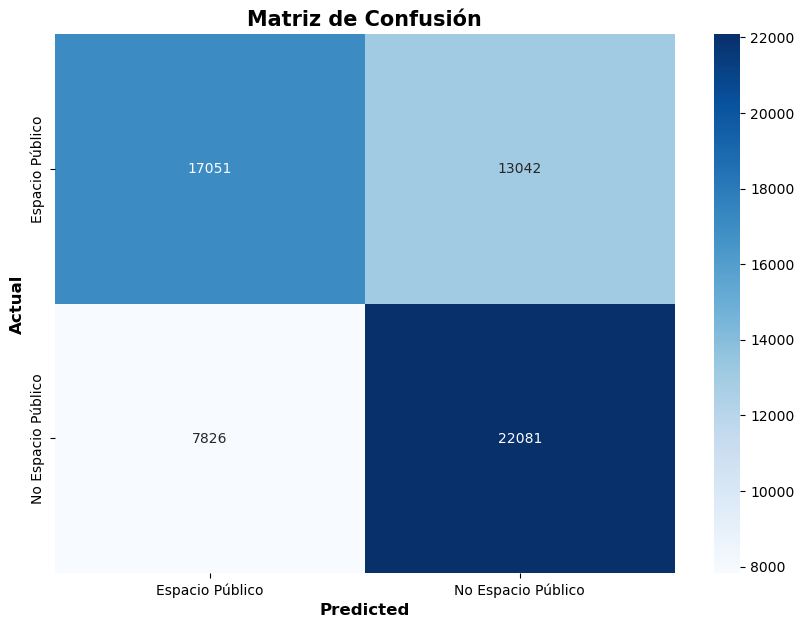

In [18]:
clf = LogisticRegression()
clf.fit(x_train_scale, y_train)
y_pred = clf.predict(x_test_scale)
cm = confusion_matrix(y_test,y_pred)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [19]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6522


### Naive Bayes

In [20]:
nb = GaussianNB()
nb.fit(x_train, y_train)

GaussianNB()

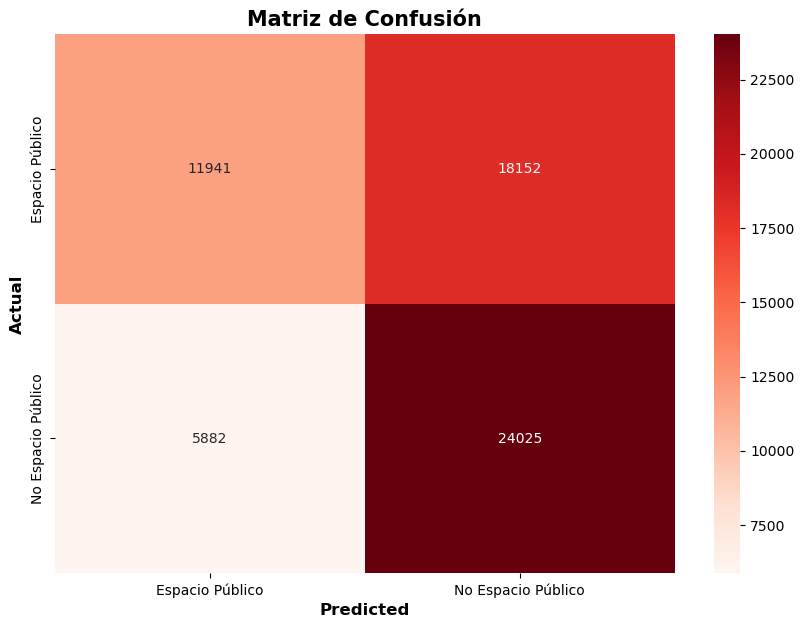

In [21]:
y_prend = nb.predict(x_test)
cm = confusion_matrix(y_test, y_prend)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [22]:
accuracy = accuracy_score(y_test, y_prend)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5994333333333334


## Random Forest Classifier (RFC)

In [23]:
rf = RandomForestClassifier(n_estimators=120, random_state=42)  
rf.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_predd = rf.predict(x_test)

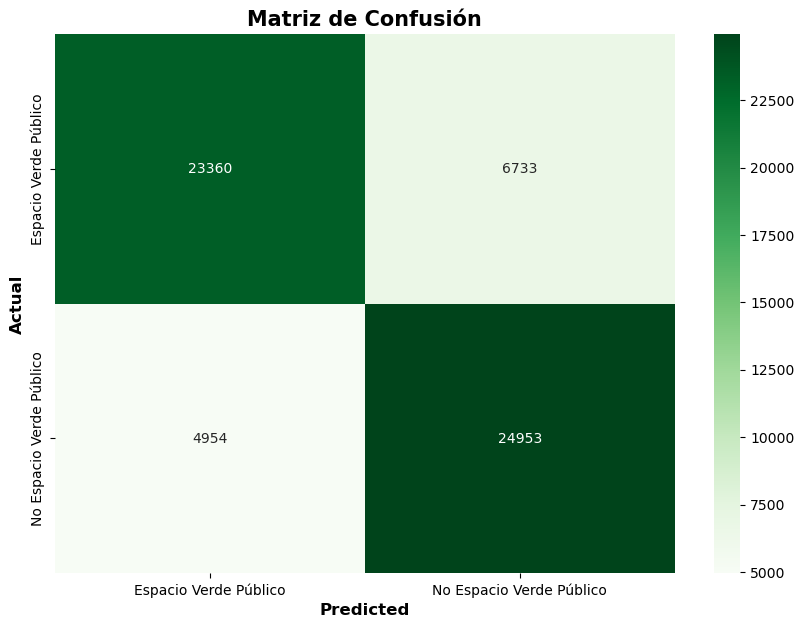

In [24]:
cm = confusion_matrix(y_test, y_predd)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [25]:
accuracy = accuracy_score(y_test, y_predd)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8052166666666667


### Optimización Hiperparámetros para obtener la mejor combinación

#### GridSearch

In [18]:
param_grid = { 
    'n_estimators': [25, 50, 100, 125, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
}  

Como tiene mucho costo computacional el hacer una búsqueda exhaustiva y tenemos muchos datos. Voy a hacer un subsample nada más para sacar los mejores híper parámetros y ya después aplicarlos al completo.

In [24]:
sample_size = 10000  
x_train_sample = x_train[:sample_size]
y_train_sample = y_train[:sample_size]
grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid) 
grid_search.fit(x_train_sample, y_train_sample) 
print(grid_search.best_estimator_) 

RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9)


In [25]:
rf_grid = RandomForestClassifier(max_depth=6, 
                                    max_features=None, 
                                    max_leaf_nodes=9,
                                    n_estimators=120, 
                                    random_state=42)  
rf_grid.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_grid = rf_grid.predict(x_test)

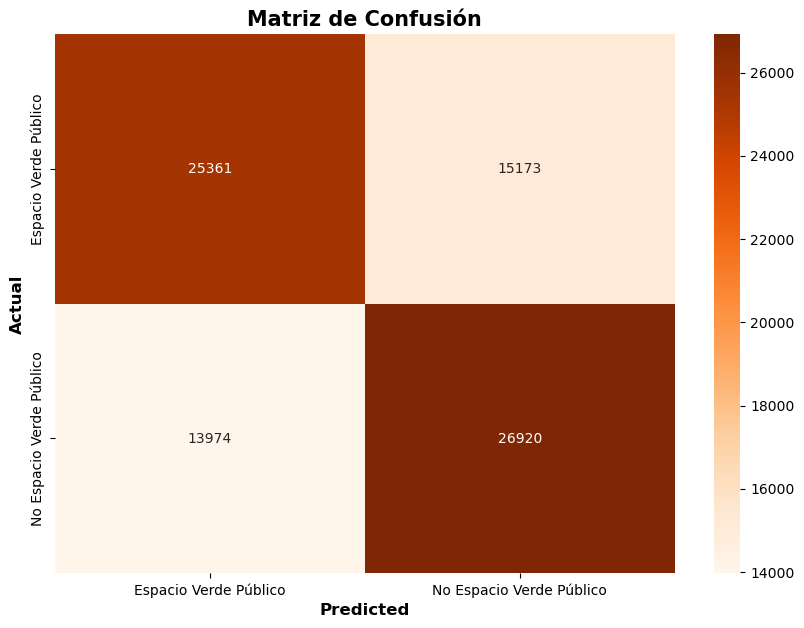

In [26]:
cm = confusion_matrix(y_test, y_pred_grid)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Oranges", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [27]:
accuracy = accuracy_score(y_test, y_pred_grid)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6420518740482389


Vemos que esos parámetros empeoran terriblemente el accuracy

#### Randomized Search

In [28]:
random_search = RandomizedSearchCV(RandomForestClassifier(), 
                                   param_grid, n_iter=10, n_jobs=-1) 
random_search.fit(x_train, y_train) 
print(random_search.best_estimator_) 

RandomForestClassifier(max_depth=3, max_features=None, max_leaf_nodes=6)


In [29]:
rf_random = RandomForestClassifier(max_depth=3, 
                                    max_features=None, 
                                    max_leaf_nodes=6,
                                    n_estimators=120, 
                                    random_state=42)  
rf_random.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_random = rf_random.predict(x_test)

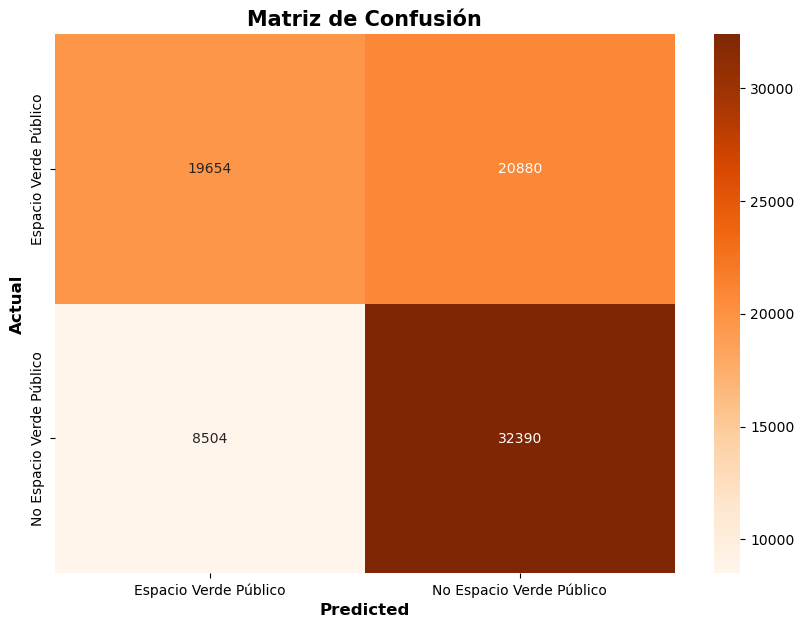

In [30]:
cm = confusion_matrix(y_test, y_pred_random)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Oranges", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [31]:
accuracy = accuracy_score(y_test, y_pred_random)
print(f'Accuracy: {accuracy}')

Accuracy: 0.63914132730756


#### Ensemble Methods

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Example: Using AdaBoost as an ensemble method
ada_boost_model = AdaBoostClassifier(base_estimator=RandomForestClassifier(), n_estimators=50)
ada_boost_model.fit(x_train, y_train)

In [ ]:
y_pred_ada = ada_boost_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred_ada)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Oranges", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_pred_ada)
print(f'Accuracy: {accuracy}')

## XGBoost

In [26]:
xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)

# Ajustar el modelo a los datos de entrenamiento
xgb_classifier.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_predict = xgb_classifier.predict(x_test)

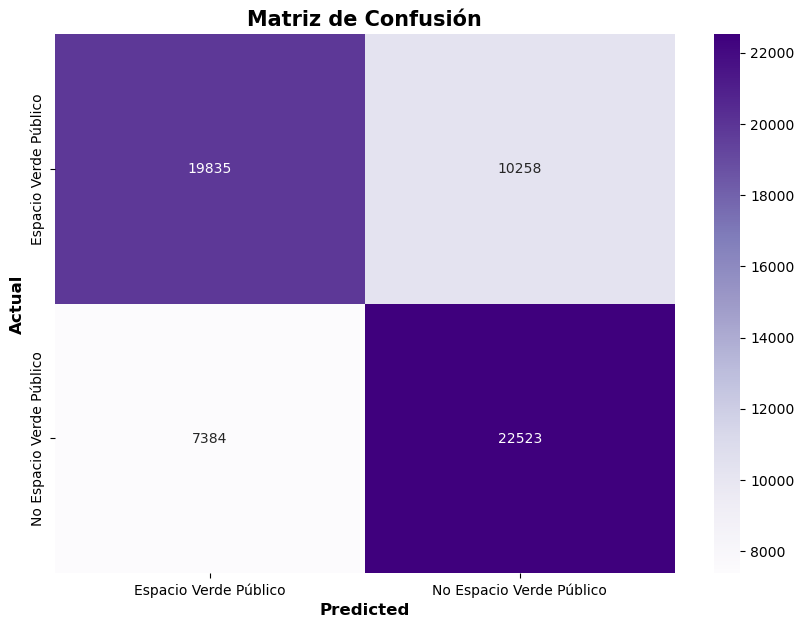

In [27]:
cm = confusion_matrix(y_test, y_predict)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Purples", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [28]:
accuracy = accuracy_score(y_test, y_predict)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7059666666666666


Podemos observar que al tener menos datos la clasificación con Naive Bayes, XGBoost y Regresión logística salió peor que con toda la información. Sin embargo, el random forest classifier es el que mejor, ha predecido con un 90% de precisión.

## Clasificación del modelo Perceptrón

In [ ]:
n_clases = len(y.unique())
n_features = len(x.columns)

x = x.values
output_y = y.values

# Define MLP model
clf = Sequential()
clf.add(Dense(180, input_dim=n_features, activation='relu'))
clf.add(Dense(180, activation='relu'))
clf.add(Dense(1, activation='sigmoid')) 

# Compile model
clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit model
clf.fit(x, output_y, epochs=30, batch_size=10)


# Evaluate model with crossvalidation
kf = StratifiedKFold(n_splits=5, shuffle = True)

cv_y_test = []
cv_y_pred = []

for train_index, test_index in kf.split(x, y):

    x_train = x[train_index, :]
    y_train = y[train_index]

    x_test = x[test_index, :]
    y_test = y[test_index]

    # Training phase
    clf_cv = Sequential()
    clf_cv.add(Dense(180, input_dim=n_features, activation='relu'))
    clf_cv.add(Dense(180, activation='relu'))
    clf_cv.add(Dense(1, activation='sigmoid'))
    clf_cv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    clf_cv.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=30, batch_size=10)

    # Test phase
    x_test = x[test_index, :]
    y_test = y[test_index]
    y_pred = [0 if valor < 0.5 else 1 for valor in clf_cv.predict(x_test)]
    
    cv_y_test.append(y_test)
    cv_y_pred.append(y_pred)

# Results
print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))

Epoch 1/30
40000/40000 [==============================] - 309s 8ms/step - loss: 0.6103 - accuracy: 0.6567
Epoch 2/30
40000/40000 [==============================] - 308s 8ms/step - loss: 0.5985 - accuracy: 0.6696
Epoch 3/30
40000/40000 [==============================] - 301s 8ms/step - loss: 0.5944 - accuracy: 0.6736
Epoch 4/30
40000/40000 [==============================] - 320s 8ms/step - loss: 0.5917 - accuracy: 0.6760
Epoch 5/30
40000/40000 [==============================] - 368s 9ms/step - loss: 0.5901 - accuracy: 0.6781
Epoch 6/30
40000/40000 [==============================] - 247s 6ms/step - loss: 0.5884 - accuracy: 0.6794
Epoch 7/30
40000/40000 [==============================] - 294s 7ms/step - loss: 0.5871 - accuracy: 0.6809
Epoch 8/30
40000/40000 [==============================] - 258s 6ms/step - loss: 0.5856 - accuracy: 0.6819
Epoch 9/30
40000/40000 [==============================] - 250s 6ms/step - loss: 0.5849 - accuracy: 0.6826
Epoch 10/30
40000/40000 [=====================